/tmp/ipython-input-32-3572071214.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elasticity = category_daily.groupby('category', group_keys=False).apply(
/tmp/ipython-input-32-3572071214.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=elasticity, x='category', y='elasticity', palette='coolwarm')


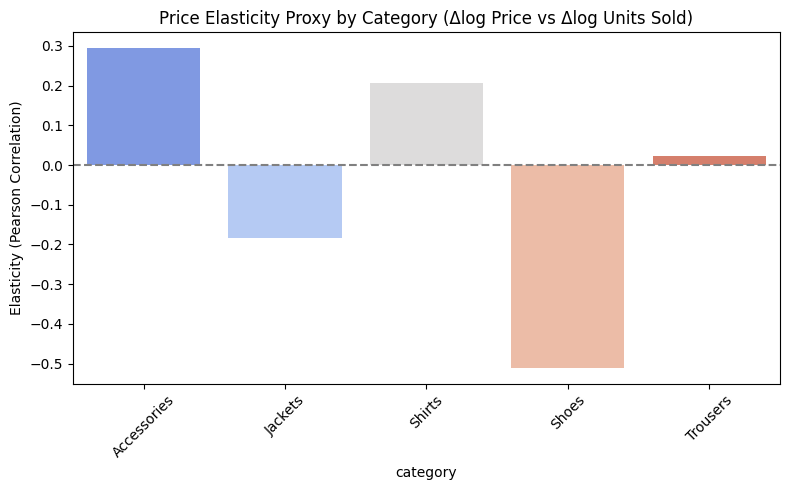

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
daily_sales = pd.read_csv('daily_sales.csv')
products = pd.read_csv('products.csv')

# Merge with category and price info
sales_price = daily_sales.merge(products[['style_code', 'category', 'price']], on='style_code', how='left')

# Drop rows where gross_value = 0
sales_price = sales_price[sales_price['gross_value'] != 0]

# Convert date
sales_price['snapshot_date'] = pd.to_datetime(sales_price['snapshot_date'])

# Filter last 60 days
latest_date = sales_price['snapshot_date'].max()
date_cutoff = latest_date - pd.Timedelta(days=59)
sales_60 = sales_price[sales_price['snapshot_date'] >= date_cutoff]

# Group by category and date
category_daily = sales_60.groupby(['category', 'snapshot_date']).agg({
    'price': 'mean',
    'units_sold': 'sum'
}).reset_index()

# Log transforms
category_daily['log_price'] = np.log(category_daily['price'])
category_daily['log_units'] = np.log(category_daily['units_sold'])

# Calculate deltas
category_daily['delta_log_price'] = category_daily.groupby('category')['log_price'].diff()
category_daily['delta_log_units'] = category_daily.groupby('category')['log_units'].diff()

# Compute Pearson correlation per category
elasticity = category_daily.groupby('category', group_keys=False).apply(
    lambda x: x[['delta_log_price', 'delta_log_units']].corr().iloc[0, 1]
).dropna().reset_index(name='elasticity')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=elasticity, x='category', y='elasticity', palette='coolwarm')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Price Elasticity Proxy by Category (Δlog Price vs Δlog Units Sold)')
plt.ylabel('Elasticity (Pearson Correlation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()